# GANs  Roses


In [8]:
import numpy as np

In [9]:
import os
from glob import glob
import cv2

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
PATH = '/kaggle/input/flowers-recognition/flowers/rose'
IMGS = glob(os.path.join(PATH, "*.jpg"))

print(len(IMGS)) # number of the rose images
print(IMGS[:10]) # rose images filenames

784
['/kaggle/input/flowers-recognition/flowers/rose/18492302751_cf6a5a583e_n.jpg', '/kaggle/input/flowers-recognition/flowers/rose/5002446424_b86e3c646f_n.jpg', '/kaggle/input/flowers-recognition/flowers/rose/6108118824_5b0231a56d.jpg', '/kaggle/input/flowers-recognition/flowers/rose/2265390547_2409007cef_n.jpg', '/kaggle/input/flowers-recognition/flowers/rose/2501297526_cbd66a3f7e_m.jpg', '/kaggle/input/flowers-recognition/flowers/rose/5349861432_96137002c4_n.jpg', '/kaggle/input/flowers-recognition/flowers/rose/16078501836_3ac067e18a.jpg', '/kaggle/input/flowers-recognition/flowers/rose/13264214185_d6aa79b3bd.jpg', '/kaggle/input/flowers-recognition/flowers/rose/2888138918_402096c7fb.jpg', '/kaggle/input/flowers-recognition/flowers/rose/7304710956_015b41f802_m.jpg']


Then we resize the images to WIDTH pixels width, HEIGHT pixels height, and DEPTH color channels)

In [11]:
WIDTH = 28
HEIGHT = 28
DEPTH = 3

In [12]:
def procImages(images):
    processed_images = []
    
    # set depth
    depth = None
    if DEPTH == 1:
        depth = cv2.IMREAD_GRAYSCALE
    elif DEPTH == 3:
        depth = cv2.IMREAD_COLOR
    else:
        print('DEPTH must be set to 1 or to 3.')
        return None
    
    #resize images
    for img in images:
        base = os.path.basename(img)
        full_size_image = cv2.imread(img, depth)
        processed_images.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
    processed_images = np.asarray(processed_images)
    
    # rescale images to [-1, 1]
    processed_images = np.divide(processed_images, 127.5) - 1

    return processed_images

In [13]:
processed_images = procImages(IMGS)
processed_images.shape

(784, 28, 28, 3)

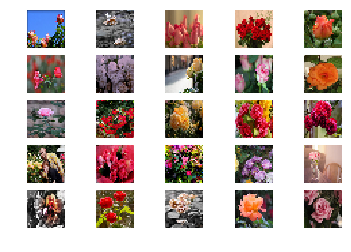

In [14]:
fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        img = processed_images[count, :, :, :] * 127.5 + 127.5
        img = np.asarray(img, dtype=np.uint8)
        if DEPTH == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        count += 1
plt.show()

## Building Simple GAN Model

Below we create functions for building simple dense generator and a discriminator modelsa

In [16]:
# GAN parameters
LATENT_DIM = 100
G_LAYERS_DIM = [256, 512, 1024]
D_LAYERS_DIM = [1024, 512, 256]

BATCH_SIZE = 16
EPOCHS = 1000
LR = 0.0002
BETA_1 = 0.5

In [17]:
def buildGenerator(img_shape):

    def addLayer(model, dim):
        model.add(Dense(dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
    model = Sequential()
    model.add(Dense(G_LAYERS_DIM[0], input_dim=LATENT_DIM))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    for layer_dim in G_LAYERS_DIM[1:]:
        addLayer(model, layer_dim)
        
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(LATENT_DIM,))
    img = model(noise)

    return Model(noise, img)

In [18]:
#g = buildGenerator(processed_images.shape[1:])

In [19]:
def buildDiscriminator(img_shape):

    def addLayer(model, dim):
        model.add(Dense(dim))
        model.add(LeakyReLU(alpha=0.2))

    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    
    for layer_dim in D_LAYERS_DIM:
        addLayer(model, layer_dim)
        
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    classification = model(img)

    return Model(img, classification)

In [ ]:
#d = buildDiscriminator(processed_images.shape[1:])

In [20]:
def buildCombined(g, d):
    # fix d for training g in the combined model
    d.trainable = False

    # g gets z as input and outputs fake_img
    z = Input(shape=(LATENT_DIM,))
    fake_img = g(z)

    # gets the classification of the fake image
    gan_output = d(fake_img)

    # the combined model for training generator g to fool discriminator d
    model = Model(z, gan_output)
    model.summary()
    
    return model

In [26]:
def sampleImages(generator):
    rows, columns = 5, 5
    noise = np.random.normal(0, 1, (rows * columns, LATENT_DIM))
    generated_imgs = generator.predict(noise)

    fig, axs = plt.subplots(rows, columns)
    count = 0
    for i in range(rows):
        for j in range(columns):
            img = generated_imgs[count, :, :, :] * 127.5 + 127.5
            img = np.asarray(img, dtype=np.uint8)
            if DEPTH == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            count += 1
    plt.show()

In [ ]:
#sampleImages(g)

In [21]:
#instantiate the optimizer
optimizer = Adam(LR, BETA_1)

In [22]:
#build the discriminator
d = buildDiscriminator(processed_images.shape[1:])
d.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2409472   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
__________

In [23]:
#build generator
g = buildGenerator(processed_images.shape[1:])
g.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
__________

In [24]:
#build combined model
c = buildCombined(g, d)
c.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 3)         3100720   
_________________________________________________________________
model_1 (Model)              (None, 1)                 3065857   
Total params: 6,166,577
Trainable params: 3,097,136
Non-trainable params: 3,069,441
_________________________________________________________________


0 [Discriminator Loss: 0.49183717370033264, Acc.: 43.75%] [Generator Loss: 1.6589438915252686]


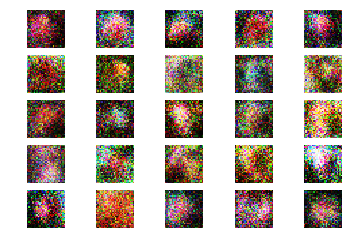

99 [Discriminator Loss: 0.5344628095626831, Acc.: 50.00%] [Generator Loss: 1.6260969638824463]


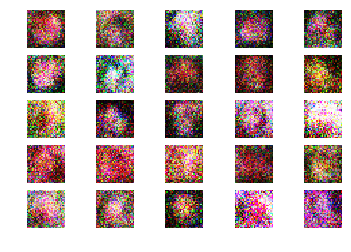

199 [Discriminator Loss: 0.545662522315979, Acc.: 50.00%] [Generator Loss: 1.1708954572677612]


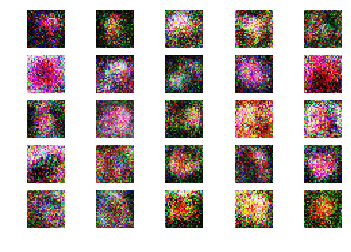

299 [Discriminator Loss: 0.5382587909698486, Acc.: 40.62%] [Generator Loss: 1.7929607629776]


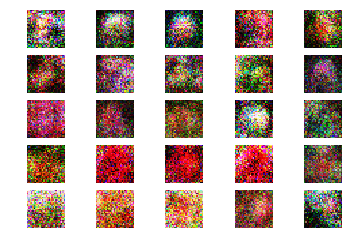

399 [Discriminator Loss: 0.489635705947876, Acc.: 50.00%] [Generator Loss: 1.684991717338562]


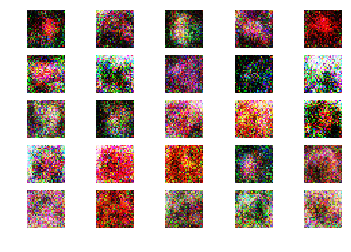

499 [Discriminator Loss: 0.5145426988601685, Acc.: 50.00%] [Generator Loss: 1.2445318698883057]


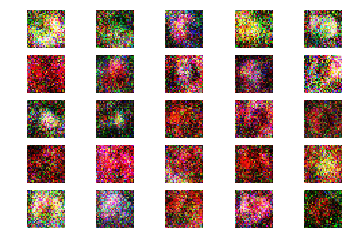

599 [Discriminator Loss: 0.43938350677490234, Acc.: 46.88%] [Generator Loss: 1.917675495147705]


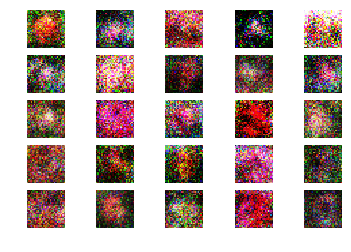

699 [Discriminator Loss: 0.39169013500213623, Acc.: 50.00%] [Generator Loss: 1.896077036857605]


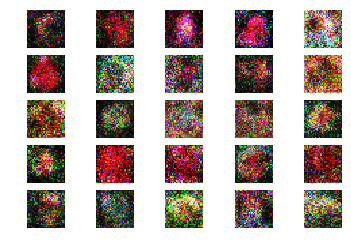

799 [Discriminator Loss: 0.5235624313354492, Acc.: 50.00%] [Generator Loss: 1.1841906309127808]


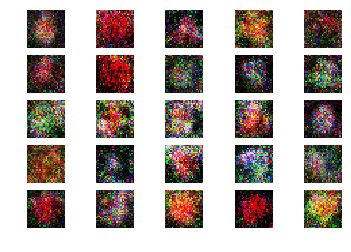

899 [Discriminator Loss: 0.4356119632720947, Acc.: 46.88%] [Generator Loss: 1.583680272102356]


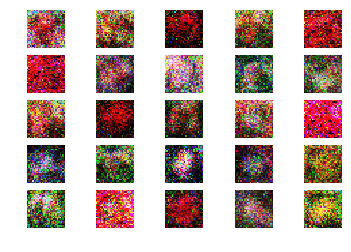

999 [Discriminator Loss: 0.41138964891433716, Acc.: 46.88%] [Generator Loss: 2.4203855991363525]


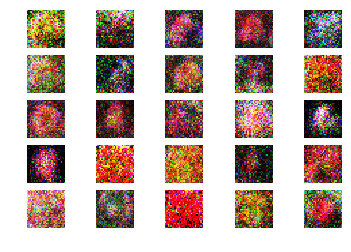

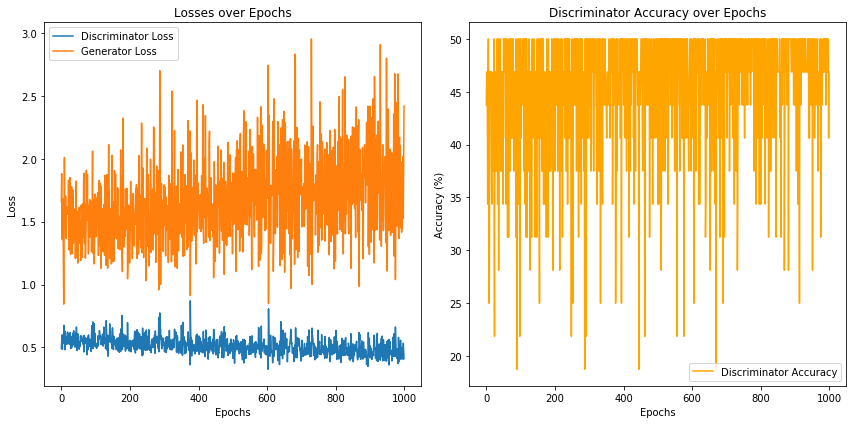

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize arrays to store loss and accuracy values for plotting
d_losses = []
g_losses = []
d_accuracies = []

SAMPLE_INTERVAL = WARNING_INTERVAL = 100

YDis = np.zeros(2 * BATCH_SIZE)
YDis[:BATCH_SIZE] = 0.9  # Label smoothing for real images

YGen = np.ones(BATCH_SIZE)

for epoch in range(EPOCHS):
    # Get a batch of real images
    idx = np.random.randint(0, processed_images.shape[0], BATCH_SIZE)
    real_imgs = processed_images[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_imgs = g.predict(noise)

    # Combine real and fake images
    X = np.concatenate([real_imgs, fake_imgs])

    # Train discriminator
    d.trainable = True
    d_loss = d.train_on_batch(X, YDis)

    # Train the generator
    d.trainable = False
    g_loss = c.train_on_batch(noise, YGen)

    # Store the discriminator loss and accuracy, and generator loss
    d_losses.append(d_loss[0])
    d_accuracies.append(100. * d_loss[1])
    g_losses.append(g_loss)

    # Progress update
    if (epoch + 1) % WARNING_INTERVAL == 0 or epoch == 0:
        print(f"{epoch} [Discriminator Loss: {d_loss[0]}, Acc.: {100. * d_loss[1]:.2f}%] [Generator Loss: {g_loss}]")

    # Save sample images at sample intervals
    if (epoch + 1) % SAMPLE_INTERVAL == 0 or epoch == 0:
        sampleImages(g)

# After training, plot the losses and accuracy
plt.figure(figsize=(12, 6))

# Plot Discriminator and Generator losses
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Losses over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Discriminator accuracy
plt.subplot(1, 2, 2)
plt.plot(d_accuracies, label="Discriminator Accuracy", color='orange')
plt.title("Discriminator Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
